In [37]:
from cosmikyu import maps, config
from cosmikyu import transforms as cmk_transforms
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pixell import enmap, enplot
from orphics import maps as omaps

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
output_dir = config.default_data_dir
def output_path(x):
    return os.path.join(output_dir, x)

res_arcmin = 2.0
shape = (150, 150)
stamp_dir = output_path("stamp_{}arcmin_{}x{}".format(res_arcmin, shape[0], shape[1]))

SS = maps.StampedSky(stamp_dir, res_arcmin, shape)
SSDS = maps.StampedSkyDataSet(stamp_dir, 3000, res_arcmin, 'ir_pts', 30, shape)

In [77]:
class Taper(object):
    def __init__(self, shape):
        self.shape = shape
        self.taper, _ = omaps.get_taper(shape, pad_percent=0.)
        loc = self.taper == 0
        self.taper[loc] = np.min(self.taper[~loc])
        
        
    def __call__(self, sample):
        assert('map' in sample)
        sample['map'] = sample['map']*self.taper
        return sample
    
class UnTaper(object):
    def __init__(self, shape):
        self.shape = shape
        self.taper, _ = omaps.get_taper(shape, pad_percent=0.)
        loc = self.taper == 0
        self.taper[loc] = np.min(self.taper[~loc])
        
    def __call__(self, sample):
        assert('map' in sample)
        sample['map'] = np.nan_to_num(sample['map']/self.taper)
        return sample
    
class TakePS(object):
    def __init__(self, bin_edges, shape, is_tapered=False, return_dl=True):
        self.bin_edges = bin_edges
        self.shape = shape
        self.taper, _ = omaps.get_taper(shape)
        loc = self.taper == 0
        self.taper[loc] = np.min(self.taper[~loc])
        self.is_tapered = False
        self.return_dl = return_dl
        
    def __call__(self, sample):
        emap = sample['map'].copy() if 'map' in sample else  enmap.enmap(sample['data'], wcs=sample['wcs'])
        if self.is_tapered:
            emap = np.nan_to_num(emap/self.taper)
        lbin, ps = omaps.binned_power(emap, self.bin_edges, mask=self.taper)
        ps = ps if not self.return_dl else ps*(lbin*(lbin+1)/(2*np.pi))
        
        sample['ps'] = (lbin, np.nan_to_num(ps))
        return sample
            
        
        
        


84.58900221355678 -3.723751341696494
84.58900221355634 -3.7237513416964703
3.113306450976529e-12


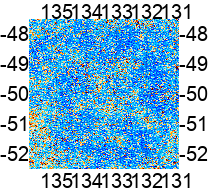

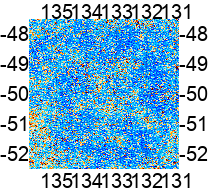

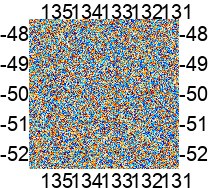

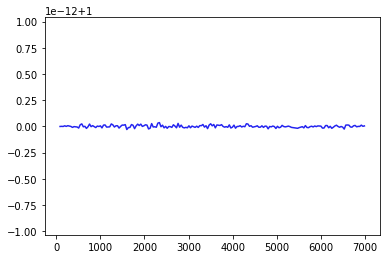

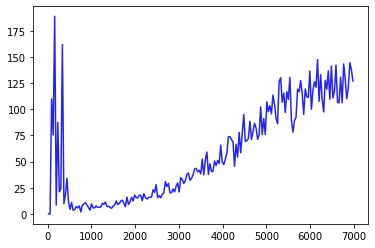

In [81]:
LS = cmk_transforms.LogScale()
np.mean(LS.__call__(SSDS[30])['data'])



meta = np.loadtxt(output_path('ir_pts/030_meta.txt'))
sample = SSDS[5]
#sample['data'] = np.ones(sample['data'].shape)*-1
omap = enmap.enmap(sample['data'], wcs=sample['wcs'])

#oloc = np.where(omap > 0)
NN = cmk_transforms.Normalize(meta)
UN = cmk_transforms.UnNormalize(meta)
TE = cmk_transforms.ToEnmap()
TT = Taper(shape)
UT = UnTaper(shape)
PS = TakePS(bin_edges=np.linspace(0,7000,200), shape=shape)
ops = PS.__call__(sample)['ps']

sample = PS.__call__((TE.__call__(UN.__call__(NN.__call__(sample)))))
fmap = sample['map']
floc = np.where(fmap < 0)
print(np.max(omap), np.min(omap))
print(np.max(fmap), np.min(fmap))
print(np.max(np.abs(np.nan_to_num((fmap-omap)/omap))))
enplot.pshow(omap, downgrade=1)
enplot.pshow(fmap, downgrade=1)
enplot.pshow(omap-fmap, downgrade=1)

#print(sample['ps'])
plt.plot(sample['ps'][0], ops[1]/sample['ps'][1])
plt.show()

plt.plot(sample['ps'][0], ops[1])
plt.show()